Change the positions of the galaxies in a SHAM to be shuffled then NFW-distributed, instead of on the subhalos. 

Shuffling procedure is as followed, from Jeremey

procedure:

take a bin in halo mass (small bins, like 0.1dex wide). (this is all halos, regardless of whether they have a galaxy in them or not). take all the centrals and put them in a list. take all the satellites and put them in a separate list.

randomly assign the centrals to all the halos in the bin.

randomly assign each satellite to a halo in the bin (repeat until all satellites are gone. this should preserve poisson distribution of satellite occupation). when assigning a satellite to a halo, preserve the position of the satellite and velocity of the satellite relative to the original host halo. ie, your list of satllites has dx, dy, dz, and dvx, dvy, dvz, then you add x, y, z, and vx, vy, vz of the new halo to those quantities.

In [32]:
import numpy as np
import astropy
from itertools import izip
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.utils import *

In [33]:
from halotools.mock_observables import tpcf

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [35]:
Lbox = 1000.0
#catalog = np.loadtxt('ab_sham_hod_data_cut.npy')

ab_property = 'halo_vmax@mpeak'
catalog = astropy.table.Table.read('../catalog_ab_%s_fixed_large.hdf5'%ab_property, format = 'hdf5')

In [36]:
catalog.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_vmax@mpeak',
 'halo_rvir',
 'halo_mpeak',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_hostid',
 'halo_mvir_host_halo',
 'gal_smass']

In [37]:
PMASS = 7.62293e+07
nd = 4.2e-4 #nd of final cat 
n_obj_needed = int(nd*(Lbox**3))

In [38]:
add_halo_hostid(catalog, delete_possibly_existing_column=True)

In [39]:
for prop in ['halo_x', 'halo_y', 'halo_z','halo_vx', 'halo_vy', 'halo_vz', 'halo_nfw_conc', 'halo_rvir']:
    broadcast_host_halo_property(catalog, prop, delete_possibly_existing_column=True)

In [40]:
len(catalog)

95969198

In [41]:
catalog.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_vmax@mpeak',
 'halo_rvir',
 'halo_mpeak',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_mvir_host_halo',
 'gal_smass',
 'halo_hostid',
 'halo_x_host_halo',
 'halo_y_host_halo',
 'halo_z_host_halo',
 'halo_vx_host_halo',
 'halo_vy_host_halo',
 'halo_vz_host_halo',
 'halo_nfw_conc_host_halo',
 'halo_rvir_host_halo']

In [42]:
from halotools.utils.table_utils import compute_prim_haloprop_bins
from math import ceil
min_log_mass = np.log10(np.min(catalog['halo_mvir']))-0.001
max_log_mass = np.log10(np.max(catalog['halo_mvir']))+0.001
print min_log_mass, max_log_mass
dlog10_prim_haloprop = 0.1
num_prim_haloprop_bins = (max_log_mass - min_log_mass) / dlog10_prim_haloprop
prim_haloprop_bin_boundaries = np.logspace(min_log_mass, max_log_mass,
    num=int(ceil(num_prim_haloprop_bins)))

prim_haloprop_bins = compute_prim_haloprop_bins(prim_haloprop = catalog['halo_mvir_host_halo'],\
                                                dlog10_prim_haloprop=dlog10_prim_haloprop,
                                                prim_haloprop_bin_boundaries = prim_haloprop_bin_boundaries)

9.68749945068 15.2108903656


In [43]:
shuffled_pos = np.zeros((len(catalog), 3))
shuffled_vel = np.zeros((len(catalog), 3))
shuffled_upids = np.zeros((len(catalog)))
shuffled_host_mvir = np.zeros((len(catalog)))

In [44]:
shuffled_mags = np.zeros((len(catalog), 1))
#shuffled_mags[:, 0] = catalog['halo_vpeak_mag']
#shuffled_mags[:, 1] = catalog['halo_vvir_mag']
#shuffled_mags[:, 2] = catalog['halo_alpha_05_mag']

In [45]:
bins_in_halocat = set(prim_haloprop_bins)

for ibin in bins_in_halocat:
    print ibin
    #if ibin > 25:
    #    continue
    indices_of_prim_haloprop_bin = np.where(prim_haloprop_bins == ibin)[0]
    
    centrals_idx = np.where(catalog[indices_of_prim_haloprop_bin]['halo_upid'] == -1)[0]
    n_centrals = len(centrals_idx)
    satellites_idx = np.where(catalog[indices_of_prim_haloprop_bin]['halo_upid']!=-1)[0]
    n_satellites = len(satellites_idx)
    
    if centrals_idx.shape[0]!=0:
        rand_central_idxs = np.random.choice(indices_of_prim_haloprop_bin[centrals_idx], size = n_centrals, replace = False)
    else:
        rand_central_idxs = np.array([])
        
    shuffled_mags[indices_of_prim_haloprop_bin[centrals_idx],0]= \
            catalog[rand_central_idxs]['gal_smass']

    shuffled_mags[indices_of_prim_haloprop_bin[satellites_idx],0] = \
            catalog[indices_of_prim_haloprop_bin[satellites_idx]]['gal_smass']
    #Create second rand_central_idxs, Iterate through satellite hosts and assign them when they match. 
                
    for idx, coord in enumerate(['x','y','z']):
        # don't need to shuffle positions cu we've shuffled mags for centrals
        shuffled_pos[indices_of_prim_haloprop_bin[centrals_idx], idx] = \
                catalog[indices_of_prim_haloprop_bin[centrals_idx]]['halo_'+coord]
            
        shuffled_vel[indices_of_prim_haloprop_bin[centrals_idx], idx] = \
                catalog[indices_of_prim_haloprop_bin[centrals_idx]]['halo_v'+coord]
            
    shuffled_upids[indices_of_prim_haloprop_bin[centrals_idx]] = -1
    
    shuffled_host_mvir[indices_of_prim_haloprop_bin[centrals_idx]] = \
            catalog[indices_of_prim_haloprop_bin[centrals_idx]]['halo_mvir']
        
    unique_hosts_id, first_sat_idxs, inverse_idxs = np.unique(catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_upid'],\
                                                       return_index=True, return_inverse=True)

    shuffled_idxs = np.random.permutation(unique_hosts_id.shape[0])
    shuffled_hosts_id = unique_hosts_id[shuffled_idxs]
    shuffled_sat_idxs = first_sat_idxs[shuffled_idxs]
    shuffled_arrays_idx = 0
    host_map = dict() #maps the current host id to the index of a new host id. 
    #the host_id -> idx map is easier than the host_id -> host_id map
    
    new_host_ids = shuffled_hosts_id[inverse_idxs]
    hosts_old_satellite_idxs = shuffled_sat_idxs[inverse_idxs]
            
    shuffled_upids[indices_of_prim_haloprop_bin[satellites_idx]] = new_host_ids

    shuffled_host_mvir[indices_of_prim_haloprop_bin[satellites_idx]] = \
            catalog[indices_of_prim_haloprop_bin[satellites_idx]][hosts_old_satellite_idxs]['halo_mvir_host_halo']

    for idx, coord in enumerate(['x','y','z']):

        shuffled_pos[indices_of_prim_haloprop_bin[satellites_idx], idx] = \
                (catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_'+coord] -\
                catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_'+coord+'_host_halo']+\
                catalog[indices_of_prim_haloprop_bin[satellites_idx]][hosts_old_satellite_idxs]['halo_'+coord+'_host_halo'])%Lbox
       
        #print catalog[indices_of_prim_haloprop_bin[sat_idx]]['halo_'+coord]
        #print catalog[indices_of_prim_haloprop_bin[sat_idx]]['halo_'+coord+'_host_halo']
        #print catalog[indices_of_prim_haloprop_bin[satellites_idx]][hosts_old_satellite_idx]['halo_'+coord+'_host_halo']
        #print '*'*50       
        shuffled_vel[indices_of_prim_haloprop_bin[satellites_idx], idx] = \
                (catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_v'+coord] -\
                catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_v'+coord+'_host_halo']+\
                catalog[indices_of_prim_haloprop_bin[satellites_idx]][hosts_old_satellite_idxs]['halo_v'+coord+'_host_halo'])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [46]:
catalog['gal_smass'] = shuffled_mags[:,0]
catalog['halo_x'] = shuffled_pos[:,0]
catalog['halo_y'] = shuffled_pos[:,1]
catalog['halo_z'] = shuffled_pos[:,2]
catalog['halo_vx'] = shuffled_vel[:,0]
catalog['halo_vy'] = shuffled_vel[:,1]
catalog['halo_vz'] = shuffled_vel[:,2]
catalog['halo_upid']=shuffled_upids[:]
catalog['halo_mvir_host_halo'] = shuffled_host_mvir[:]

In [47]:
del catalog['halo_vmax@mpeak']
del catalog['halo_rvir']
del catalog['halo_mpeak']
del catalog['halo_id']
del catalog['halo_rs']
del catalog['halo_nfw_conc']
del catalog['halo_hostid']
del catalog['halo_mvir_host_halo']
del catalog['halo_x_host_halo']
del catalog['halo_y_host_halo']
del catalog['halo_z_host_halo']
del catalog['halo_vx_host_halo']
del catalog['halo_vy_host_halo']
del catalog['halo_vz_host_halo']
del catalog['halo_rvir_host_halo']
del catalog['halo_nfw_conc_host_halo']

In [48]:
nd = 4.2e-4 #nd of final cat 
n_obj_needed = int(nd*(1000.0**3))
sort_idxs = np.argsort(catalog[~np.isnan(catalog['gal_smass'])]['gal_smass'])
catalog = catalog[~np.isnan(catalog['gal_smass'])][sort_idxs[-1*n_obj_needed:]]

In [49]:
catalog.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_mvir',
 'gal_smass']

In [50]:
shuffled_pos.shape

(95969198, 3)

In [51]:
len(catalog)

420000

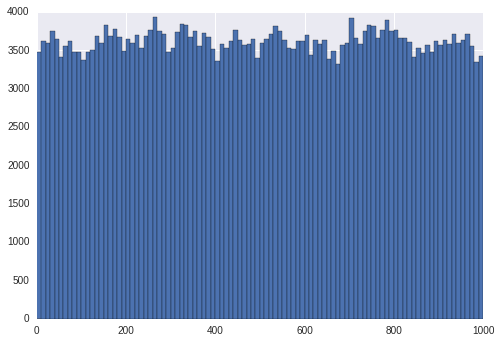

In [52]:
plt.hist(catalog[catalog['halo_upid']==-1]['halo_x'], bins = 100);

(-1, 1001)

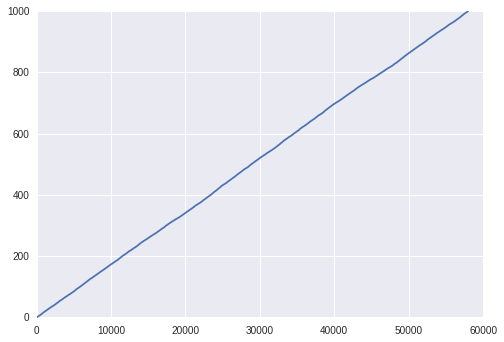

In [53]:
plt.plot(sorted(catalog['halo_x'][catalog['halo_upid']!=-1]))
#plt.yscale('log')
plt.ylim([-1, 1001])

In [54]:
from collections import Counter
c = Counter(catalog['halo_x'][catalog['halo_upid']!=-1])
print c.most_common(50)

[(596.0318603515625, 2), (737.647705078125, 2), (406.77362060546875, 2), (502.2169189453125, 2), (745.7293701171875, 2), (774.095703125, 2), (754.2705078125, 2), (964.47393798828125, 2), (739.304931640625, 2), (685.2503662109375, 2), (721.850341796875, 2), (969.6754150390625, 2), (712.3060302734375, 2), (790.64111328125, 2), (276.69985961914062, 2), (816.0792236328125, 2), (89.025650024414062, 2), (569.31756591796875, 2), (916.07513427734375, 2), (724.27703857421875, 2), (936.24151611328125, 2), (277.41281127929688, 2), (794.390625, 2), (259.14804077148438, 2), (679.2095947265625, 2), (893.242431640625, 2), (633.96923828125, 2), (374.45654296875, 2), (582.69769287109375, 2), (209.26652526855469, 2), (868.92254638671875, 2), (936.9395751953125, 2), (831.26409912109375, 2), (977.41998291015625, 2), (558.2510986328125, 2), (512.55035400390625, 2), (397.30990600585938, 2), (545.3887939453125, 2), (332.03103637695312, 2), (593.57403564453125, 2), (31.591497421264648, 2), (773.55126953125, 2

In [55]:
from halotools.mock_observables import tpcf

In [56]:
rbins = np.logspace(-1, 1.5, 15)
pos = np.c_[catalog['halo_x'], catalog['halo_y'],catalog['halo_z']]
xi = tpcf(pos, rbins, period=1000.0)

In [57]:
xi

array([  4.91672333e+03,   2.28538524e+03,   1.01371633e+03,
         4.25379692e+02,   1.40048246e+02,   4.58671134e+01,
         1.75818876e+01,   8.70366310e+00,   4.70040335e+00,
         2.45694736e+00,   1.25506718e+00,   6.21703828e-01,
         2.84249044e-01,   1.16810837e-01])

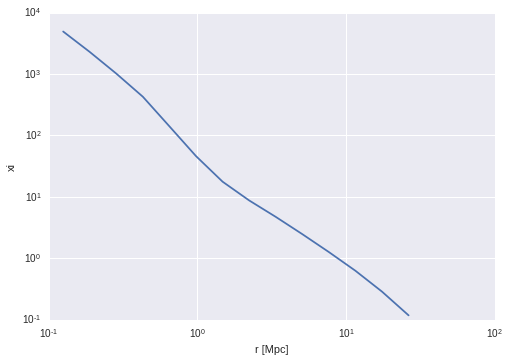

In [58]:
rbc = (rbins[1:]+rbins[:-1])/2.0
plt.plot(rbc, xi)

plt.loglog();
#plt.legend(loc='best')
plt.xlabel('r [Mpc]')
plt.ylabel('xi')

In [59]:
catalog.write('../catalog_ab_%s_shuffled_fixed.hdf5'%ab_property,
              format = 'hdf5', path = '../catalog_ab_%s_shuffled_fixed.hdf5'%ab_property, overwrite=True)

In [60]:
'catalog_ab_%s_shuffled.hdf5'%ab_property

'catalog_ab_halo_vmax@mpeak_shuffled.hdf5'

In [61]:
%%bash
ls ../*fixed.hdf5
cd ..; pwd; cd -

../catalog_ab_halo_mpeak_fixed.hdf5
../catalog_ab_halo_mpeak_shuffled_fixed.hdf5
../catalog_ab_halo_vmax@mpeak_fixed.hdf5
../catalog_ab_halo_vmax@mpeak_shuffled_fixed.hdf5
../md_catalog_ab_halo_mpeak_fixed.hdf5
../md_catalog_ab_halo_vmax@mpeak_fixed.hdf5
../md_catalog_ab_halo_vmax@mpeak_shuffled_fixed.hdf5
/nfs/slac/g/ki/ki18/des/swmclau2
/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests


In [62]:
%%bash
ls *.ipynb

AB Model Clustering Plots.ipynb
AB Model Clustering.ipynb
AB Split HOD Plots with Model clustering.ipynb
Fixed Mass Occupation 2.ipynb
Fixed Mass Occupation 3 Model.ipynb
Noisy Percentile Retread pt 2.ipynb
Noisy Percentile Retread.ipynb
Shuffle SHAM Poisson.ipynb
Shuffle SHAM Pos Dark Sky for Jeremey and Zhongxu Speedup.ipynb
Shuffle SHAM Pos Dark Sky for Jeremey and Zhongxu.ipynb
Shuffle SHAM Same Halo Speedup Attempt.ipynb
Shuffle SHAM Same Halo.ipynb
Understand Splitting Fraction Emulator.ipynb
Understand Splitting Fraction wp.ipynb
Understand Splitting Fraction.ipynb
View Chain.ipynb
View Multiple Chains.ipynb
ZhongXu SHAM Clustering Comparison.ipynb
